# Detecção de Fake News - LSTM

Base de dados usada no projeto: [ISOT Fake News Dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data)

## Importa Bibliotecas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import optuna
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Carrega Dados

In [4]:
df_train = pd.read_csv('/kaggle/input/isot-dataset-lstm/lstm_train.csv')
df_val = pd.read_csv('/kaggle/input/isot-dataset-lstm/lstm_val.csv')
df_test = pd.read_csv('/kaggle/input/isot-dataset-lstm/lstm_test.csv')

## Preparação dos dados

In [5]:
# Parâmetros principais
vocab_size = 10000  
max_len = 500 # Tamanho máximo de sequência

In [6]:
# Junta title + text (se quiser)
train_texts = df_train['title'] + " " + df_train['text']
val_texts = df_val['title'] + " " + df_val['text']
test_texts = df_test['title'] + " " + df_test['text']

# Cria e ajusta tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)  # nunca ajuste no val/test!

# Cria sequências
train_seq = tokenizer.texts_to_sequences(train_texts)
val_seq = tokenizer.texts_to_sequences(val_texts)
test_seq = tokenizer.texts_to_sequences(test_texts)

# Padding com o MESMO max_len
X_train = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
X_val = pad_sequences(val_seq, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

# Labels
y_train = df_train['labels'].values
y_val = df_val['labels'].values
y_test = df_test['labels'].values

# Transforma em tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}, y_val: {y_val_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")

X_train: torch.Size([23145, 500]), y_train: torch.Size([23145])
X_val: torch.Size([7715, 500]), y_val: torch.Size([7715])
X_test: torch.Size([7716, 500]), y_test: torch.Size([7716])


In [7]:
# Cria TensorDatasets
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

# Cria DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Tamanho do treino: {len(train_loader.dataset)}")
print(f"Tamanho da validação: {len(val_loader.dataset)}")
print(f"Tamanho do teste: {len(test_loader.dataset)}")

Tamanho do treino: 23145
Tamanho da validação: 7715
Tamanho do teste: 7716


In [8]:
_, X_sample, _, y_sample = train_test_split(
    X_train,
    y_train,
    test_size=0.4,
    stratify=y_train,
    random_state=42
)

X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(
    X_sample,
    y_sample,
    test_size=0.2,
    stratify=y_sample,
    random_state=42
)

X_train_tensor = torch.tensor(X_train_small, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_small, dtype=torch.float)
X_val_tensor = torch.tensor(X_val_small, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_small, dtype=torch.float)

train_small_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_small_ds = TensorDataset(X_val_tensor, y_val_tensor)

train_small_loader = DataLoader(train_small_ds, batch_size=32, shuffle=True)
val_small_loader = DataLoader(val_small_ds, batch_size=32, shuffle=False)

print(f"Tamanho do treino menor: {len(train_small_loader.dataset)}")
print(f"Tamanho da validação menor: {len(val_small_loader.dataset)}")

Tamanho do treino menor: 7406
Tamanho da validação menor: 1852


# Funções - Avaliação

In [9]:
class Metrics:
    def __init__(self):
        self.reset()

        # Histórico das métricas (listas)
        self.history_loss = []
        self.history_accuracy = []
        self.history_precision = []
        self.history_recall = []
        self.history_f1 = []
        self.history_auc = []

    def update(self, loss, preds, targets, outputs=None):
        """
        preds, targets: tensores long/int
        outputs: tensor float com scores antes do threshold (para AUC)
        """
        self.total_loss += loss
        self.correct += (preds == targets).sum().item()
        self.total += targets.size(0)

        # Armazena predições e alvos para cálculo das métricas ao final da época
        self.all_preds.extend(preds.cpu().numpy())
        self.all_targets.extend(targets.cpu().numpy())

        # Para AUC, precisamos das probabilidades (sigmoid outputs)
        if outputs is not None:
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            self.all_probs.extend(probs)

        self.batches += 1

    def compute(self):
        avg_loss = self.total_loss / self.batches if self.batches > 0 else 0
        accuracy = self.correct / self.total if self.total > 0 else 0

        # Calcula precisão, recall, f1 com base em todas as predições acumuladas
        precision = precision_score(self.all_targets, self.all_preds, zero_division=0)
        recall = recall_score(self.all_targets, self.all_preds, zero_division=0)
        f1 = f1_score(self.all_targets, self.all_preds, zero_division=0)

        # AUC precisa de probabilidades, caso contrário None
        try:
            auc = roc_auc_score(self.all_targets, self.all_probs) if len(set(self.all_targets)) > 1 else None
        except:
            auc = None

        # Salva no histórico
        self.history_loss.append(avg_loss)
        self.history_accuracy.append(accuracy)
        self.history_precision.append(precision)
        self.history_recall.append(recall)
        self.history_f1.append(f1)
        self.history_auc.append(auc)

        return {
            'loss': avg_loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    def reset(self):
        self.total_loss = 0.0
        self.correct = 0
        self.total = 0
        self.batches = 0

        self.all_preds = []
        self.all_targets = []
        self.all_probs = []


In [10]:
def plot_metrics_history(train_metrics, val_metrics):
    """
    Plota o histórico das métricas de treino e validação lado a lado.
    
    Args:
        train_metrics: Metrics (treino)
        val_metrics: Metrics (validação)
    """
    metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']
    histories_train = [
        train_metrics.history_loss,
        train_metrics.history_accuracy,
        train_metrics.history_precision,
        train_metrics.history_recall,
        train_metrics.history_f1,
        train_metrics.history_auc
    ]
    histories_val = [
        val_metrics.history_loss,
        val_metrics.history_accuracy,
        val_metrics.history_precision,
        val_metrics.history_recall,
        val_metrics.history_f1,
        val_metrics.history_auc
    ]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, name in enumerate(metrics_names):
        axes[idx].plot(histories_train[idx], label='Train', marker='o')
        axes[idx].plot(histories_val[idx], label='Validation', marker='x')
        axes[idx].set_title(name.capitalize())
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(name.capitalize())
        axes[idx].legend()
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

In [11]:
def eval_model(model, criterion, dataloader, metrics):
    model.eval()
    metrics.reset()
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)
            outputs = model(X_batch).squeeze(1)
            loss = criterion(outputs, y_batch)
            preds = (torch.sigmoid(outputs) > 0.5).long()
            targets = y_batch.long()

            metrics.update(loss.item(), preds, targets, outputs)

    results = metrics.compute()
    return results

In [12]:
def test_model(model, dataloader, criterion):
    model.eval()
    metrics = Metrics()
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)
            outputs = model(X_batch).squeeze(1)
            loss = criterion(outputs, y_batch)
            probs = torch.sigmoid(outputs)
            preds = (torch.sigmoid(outputs) > 0.5).long()
            targets = y_batch.long()

            metrics.update(loss.item(), preds, targets, outputs)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    results = metrics.compute()
    return results, all_preds, all_targets, all_probs

In [13]:
def plot_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(labels, positive_class_probs, title="ROC Curve"):
    """
    Plota a curva ROC e retorna a AUC.

    Parâmetros:
    - labels: array-like, rótulos verdadeiros (0 ou 1)
    - positive_class_probs: array-like, probabilidades preditas para a classe positiva
    - title: string, título do gráfico

    Retorna:
    - roc_auc: float, área sob a curva (AUC)
    """
    fpr, tpr, _ = roc_curve(labels, positive_class_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc

# Funções - Treino

In [14]:
def train(model, criterion, optimizer, early_stopping):
    train_metrics = Metrics()
    val_metrics = Metrics()

    for epoch in range(epochs):
        train_results = train_epoch(model, train_loader, criterion, optimizer, train_metrics)
        val_results = eval_model(model, criterion, val_loader, val_metrics)
    
        val_loss = val_results['loss']
        val_acc = val_results['accuracy']
    
        print(f"Epoch {epoch+1}: Train Loss={train_results['loss']:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f}")
    
        early_stopping(val_loss, model)
    
        if early_stopping.early_stop:
            print("Early stopping acionado!")
            break

    return train_metrics, val_metrics

In [15]:
def train_epoch(model, dataloader, criterion, optimizer, metrics):
    model.train()
    metrics.reset()
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        preds = (torch.sigmoid(outputs) > 0.5).long()
        targets = y_batch.long()

        metrics.update(loss.item(), preds, targets, outputs)

    results = metrics.compute()
    return results  # dict

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, mode='min', delta=0.001, path='best_model.pt'):
        """
        patience: quantas épocas esperar sem melhora
        mode: 'min' para loss, 'max' para accuracy
        delta: mínima diferença para considerar uma melhora real
        path: caminho para salvar o melhor modelo
        """
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.path = path

        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, metric_value, model):
        # Define sinal: menor ou maior é melhor
        score = -metric_value if self.mode == 'min' else metric_value

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [17]:
def train_and_evaluate(model, learning_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(6):
        model.train()
        for X_batch, y_batch in train_small_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_small_loader:
            X_val, y_val = X_val.to(device), y_val.to(device).float()
            outputs = model(X_val).squeeze(1)
            preds = torch.sigmoid(outputs) >= 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    return accuracy_score(all_labels, all_preds)

## Definição do Modelo

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 dropout=0.2, num_layers=1, bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.dropout = nn.Dropout(dropout)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, 1)  # Para BCEWithLogitsLoss

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Último hidden state
        lstm_out = self.dropout(lstm_out)
        return self.fc(lstm_out)

# Experimento 1 - LSTM unidirectional 

## Busca por Hiperparâmetros

In [30]:
# Hiperparâmetros
embedding_dim = 64
hidden_dim = 128
output_dim = 1
patience = 10

In [33]:
def objective_lstm(trial):
    # Hiperparâmetros a otimizar
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, log=True)
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, dropout, num_layers)
    model.to(device)

    return train_and_evaluate(model, learning_rate)

In [34]:
study_lstm = optuna.create_study(direction="maximize")
study_lstm.optimize(objective_lstm, n_trials=20)

[I 2025-07-30 15:47:34,939] A new study created in memory with name: no-name-d5c84c99-202e-4c64-a2b5-d94fa9e1f5d9
[I 2025-07-30 15:47:44,749] Trial 0 finished with value: 0.5480561555075594 and parameters: {'num_layers': 1, 'dropout': 0.21822103352587255, 'lr': 2.6850702054313734e-05}. Best is trial 0 with value: 0.5480561555075594.
[I 2025-07-30 15:48:03,749] Trial 1 finished with value: 0.5485961123110151 and parameters: {'num_layers': 2, 'dropout': 0.16357868928198074, 'lr': 2.5070468000716528e-05}. Best is trial 1 with value: 0.5485961123110151.
[I 2025-07-30 15:48:32,842] Trial 2 finished with value: 0.5485961123110151 and parameters: {'num_layers': 3, 'dropout': 0.3200005020260949, 'lr': 0.00010614319596471501}. Best is trial 1 with value: 0.5485961123110151.
[I 2025-07-30 15:48:51,754] Trial 3 finished with value: 0.5485961123110151 and parameters: {'num_layers': 2, 'dropout': 0.11954570446307482, 'lr': 2.7424448648155746e-05}. Best is trial 1 with value: 0.5485961123110151.
[I 

In [36]:
lstm_params = study_lstm.best_params

print("Melhores hiperparâmetros:")
print(lstm_params)

Melhores hiperparâmetros:
{'num_layers': 1, 'dropout': 0.4576103155316392, 'lr': 0.0008041095242047611}


## Treinamento

In [37]:
model = LSTMClassifier(vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=1, dropout=lstm_params['dropout'], num_layers=lstm_params['num_layers'])
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr= lstm_params['lr'])

In [38]:
early_stopping = EarlyStopping(patience=patience, mode='min', path='best_lstm2.pt')

epochs =  60
        
train_metrics, val_metrics = train(model, criterion, optimizer, early_stopping)

Epoch 1: Train Loss=0.6882 | Val Loss=0.6849 | Val Acc=0.5497
Epoch 2: Train Loss=0.6763 | Val Loss=0.6588 | Val Acc=0.6893
Epoch 3: Train Loss=0.5873 | Val Loss=0.2802 | Val Acc=0.9082
Epoch 4: Train Loss=0.1766 | Val Loss=0.1342 | Val Acc=0.9629
Epoch 5: Train Loss=0.0891 | Val Loss=0.1068 | Val Acc=0.9566
Epoch 6: Train Loss=0.0601 | Val Loss=0.0629 | Val Acc=0.9808
Epoch 7: Train Loss=0.0401 | Val Loss=0.0566 | Val Acc=0.9839
Epoch 8: Train Loss=0.0297 | Val Loss=0.0689 | Val Acc=0.9794
Epoch 9: Train Loss=0.0220 | Val Loss=0.0506 | Val Acc=0.9835
Epoch 10: Train Loss=0.0157 | Val Loss=0.0685 | Val Acc=0.9860
Epoch 11: Train Loss=0.0133 | Val Loss=0.0803 | Val Acc=0.9841
Epoch 12: Train Loss=0.0084 | Val Loss=0.0671 | Val Acc=0.9870
Epoch 13: Train Loss=0.0086 | Val Loss=0.0582 | Val Acc=0.9854
Epoch 14: Train Loss=0.0087 | Val Loss=0.0488 | Val Acc=0.9877
Epoch 15: Train Loss=0.0089 | Val Loss=0.0547 | Val Acc=0.9883
Epoch 16: Train Loss=0.0076 | Val Loss=0.0506 | Val Acc=0.9892
E

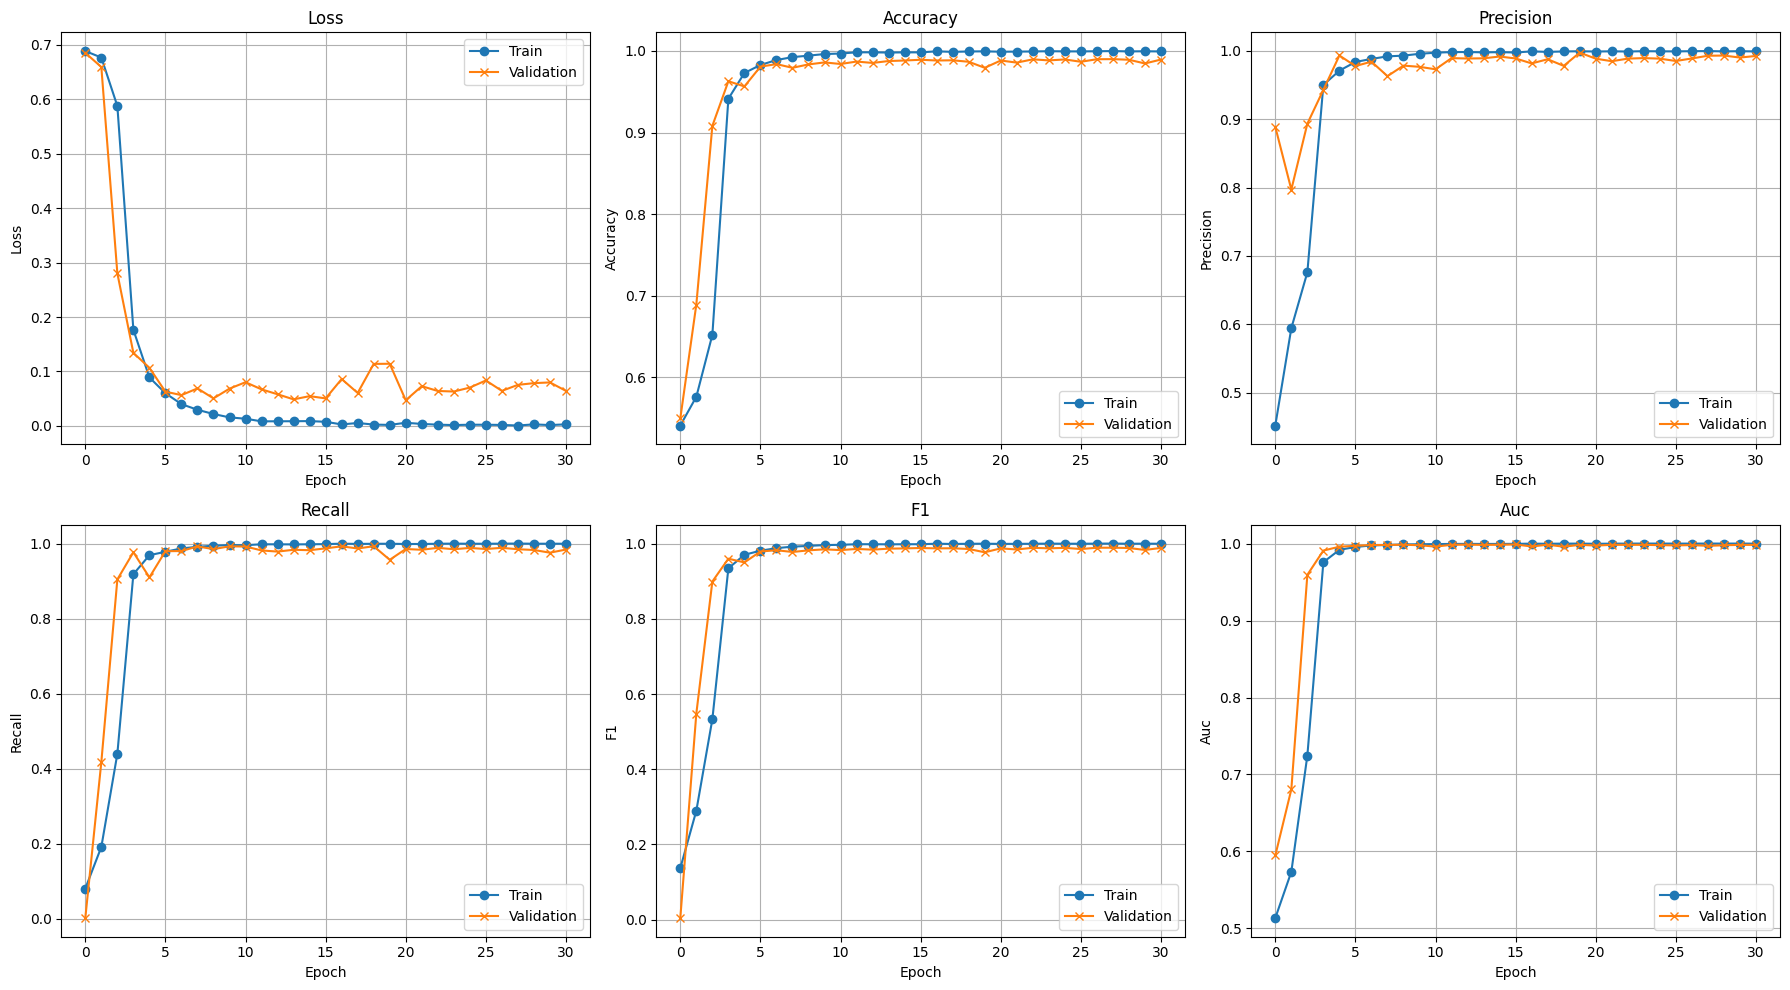

In [39]:
plot_metrics_history(train_metrics, val_metrics)

## Avaliação do Modelo

In [40]:
model.load_state_dict(torch.load('best_lstm2.pt'))

<All keys matched successfully>

In [41]:
test_results, y_pred, y_true, y_probs = test_model(model, test_loader, criterion)

print("Test Results:")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")

Test Results:
loss: 0.0492
accuracy: 0.9883
precision: 0.9905
recall: 0.9836
f1: 0.9870
auc: 0.9978


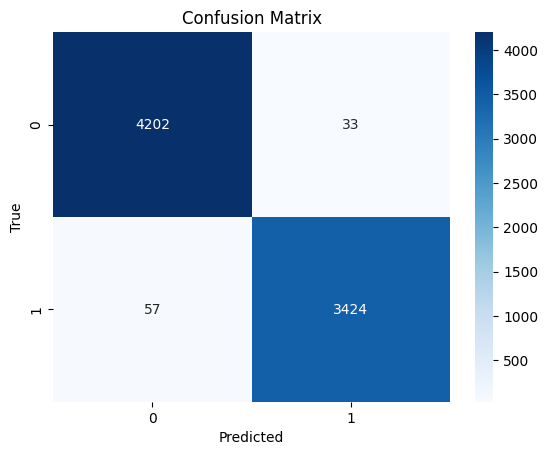

In [42]:
plot_confusion(y_true, y_pred)

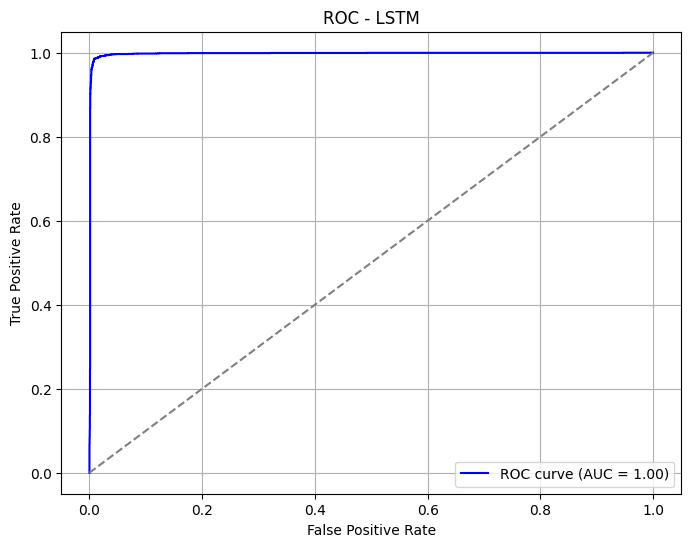

In [43]:
auc_val = plot_roc_curve(y_true, y_probs, title="ROC - LSTM")

## EXperimento 2 - BiLSTM

In [19]:
# Hiperparâmetros
embedding_dim = 64
hidden_dim = 128
output_dim = 1
patience = 10

## Busca por Hiperparâmetros

In [20]:
def objective_bilstm(trial):
    # Hiperparâmetros a otimizar
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, log=True)
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, dropout, num_layers, bidirectional=True)
    model.to(device)

    return train_and_evaluate(model, learning_rate)

In [21]:
study_bilstm = optuna.create_study(direction="maximize")
study_bilstm.optimize(objective_bilstm, n_trials=20)

[I 2025-07-30 14:48:02,360] A new study created in memory with name: no-name-38366bb3-f8cf-44e1-b999-b0c73c40b6b6
[I 2025-07-30 14:49:12,556] Trial 0 finished with value: 0.7856371490280778 and parameters: {'num_layers': 3, 'dropout': 0.4983583432036014, 'lr': 0.0002788473373957897}. Best is trial 0 with value: 0.7856371490280778.
[I 2025-07-30 14:49:29,648] Trial 1 finished with value: 0.5485961123110151 and parameters: {'num_layers': 1, 'dropout': 0.13834811216398227, 'lr': 6.722225568776479e-05}. Best is trial 0 with value: 0.7856371490280778.
[I 2025-07-30 14:51:04,476] Trial 2 finished with value: 0.5485961123110151 and parameters: {'num_layers': 4, 'dropout': 0.17639445624084038, 'lr': 7.657441980677711e-05}. Best is trial 0 with value: 0.7856371490280778.
[I 2025-07-30 14:51:47,979] Trial 3 finished with value: 0.5512958963282938 and parameters: {'num_layers': 2, 'dropout': 0.12212681055134392, 'lr': 0.00023243063342525156}. Best is trial 0 with value: 0.7856371490280778.
[I 202

In [22]:
bilstm_params = study_bilstm.best_params

print("Melhores hiperparâmetros:")
print(bilstm_params)

Melhores hiperparâmetros:
{'num_layers': 3, 'dropout': 0.23447244687064425, 'lr': 0.0009411627297790256}


## Treinamento

In [23]:
model_bi = LSTMClassifier(vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=1, dropout=bilstm_params['dropout'], num_layers=bilstm_params['num_layers'], bidirectional=True)
model_bi.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bi.parameters(), lr= bilstm_params['lr'])

In [24]:
early_stopping = EarlyStopping(patience=patience, mode='min', path='best_bilstm2.pt')

epochs =  60
        
train_metrics_bi2, val_metrics_bi2 = train(model_bi, criterion, optimizer, early_stopping)

Epoch 1: Train Loss=0.6879 | Val Loss=0.6861 | Val Acc=0.5488
Epoch 2: Train Loss=0.5888 | Val Loss=0.5993 | Val Acc=0.7017
Epoch 3: Train Loss=0.4496 | Val Loss=0.4683 | Val Acc=0.7386
Epoch 4: Train Loss=0.2946 | Val Loss=0.2301 | Val Acc=0.9148
Epoch 5: Train Loss=0.1390 | Val Loss=0.0949 | Val Acc=0.9703
Epoch 6: Train Loss=0.0665 | Val Loss=0.0581 | Val Acc=0.9833
Epoch 7: Train Loss=0.0391 | Val Loss=0.0670 | Val Acc=0.9794
Epoch 8: Train Loss=0.0263 | Val Loss=0.0513 | Val Acc=0.9860
Epoch 9: Train Loss=0.0178 | Val Loss=0.0463 | Val Acc=0.9874
Epoch 10: Train Loss=0.0149 | Val Loss=0.0444 | Val Acc=0.9886
Epoch 11: Train Loss=0.0164 | Val Loss=0.0515 | Val Acc=0.9864
Epoch 12: Train Loss=0.0073 | Val Loss=0.0764 | Val Acc=0.9859
Epoch 13: Train Loss=0.0045 | Val Loss=0.0542 | Val Acc=0.9899
Epoch 14: Train Loss=0.0058 | Val Loss=0.0495 | Val Acc=0.9891
Epoch 15: Train Loss=0.0041 | Val Loss=0.0566 | Val Acc=0.9857
Epoch 16: Train Loss=0.0047 | Val Loss=0.0664 | Val Acc=0.9894
E

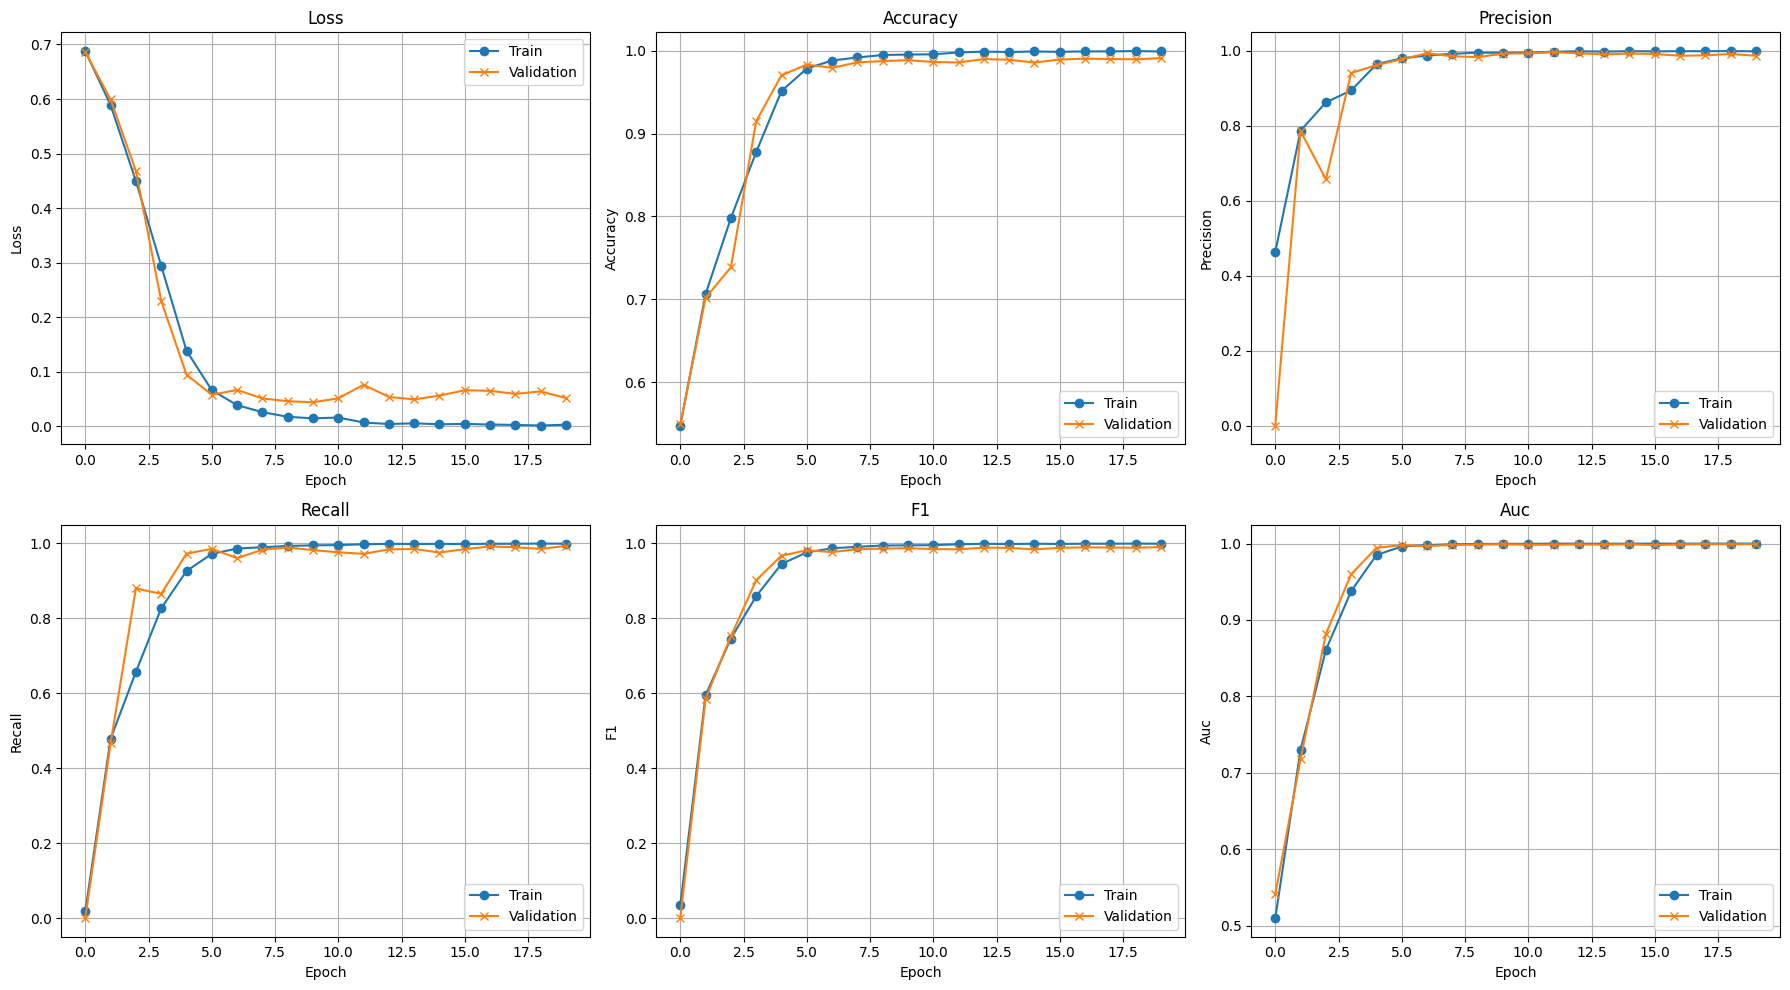

In [25]:
plot_metrics_history(train_metrics_bi2, val_metrics_bi2)

## Avaliação do Modelo

In [26]:
model_bi.load_state_dict(torch.load('best_bilstm2.pt'))

<All keys matched successfully>

In [27]:
test_results, y_pred, y_true, y_probs = test_model(model_bi, test_loader, criterion)

print("Test Results:")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")

Test Results:
loss: 0.0377
accuracy: 0.9891
precision: 0.9916
recall: 0.9842
f1: 0.9879
auc: 0.9992


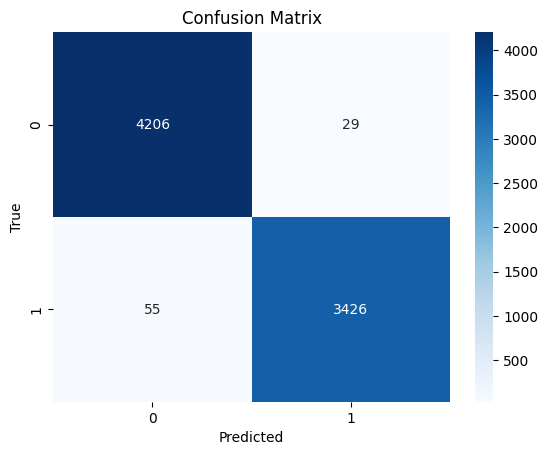

In [28]:
plot_confusion(y_true, y_pred)

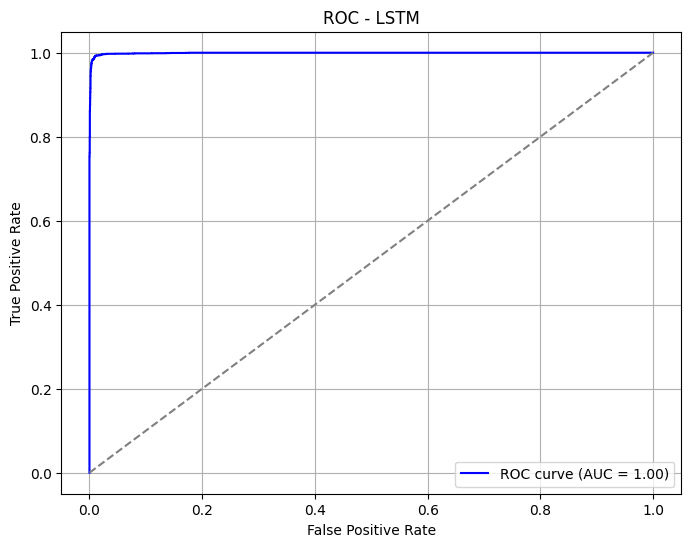

In [29]:
auc_val = plot_roc_curve(y_true, y_probs, title="ROC - LSTM")